In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-15 11:02:45.312627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-15 11:02:45.312711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-15 11:02:45.312719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.3
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.sigma = 1.18
    config.model.sigma_base = 2
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7fc60253b400>, apply=<function transform_with_state.<locals>.apply_fn at 0x7fc60253b5b0>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 1.3402754068374634)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 1.340045690536499)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 1.372581958770752)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 1.3675990104675293)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 1.3369759321212769)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 1.3347992897033691)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 1.3661448955535889)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.3172669410705566)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.3824458122253418)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.3817499876022339)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.371549129486084)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.4005820751190186)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.3571584224700928)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.3210076093673706)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.3232011795043945)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.3358969688415527)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.41022872924

('epoch: %s %s  loss: %s', 136, 'TRAIN', 1.3319751024246216)
('epoch: %s %s  loss: %s', 137, 'TRAIN', 1.3320049047470093)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 1.3259509801864624)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 1.304500937461853)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 1.3636045455932617)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 1.366374135017395)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 1.2868061065673828)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 1.3331233263015747)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 1.2860325574874878)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 1.3361058235168457)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 1.3149206638336182)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 1.283565640449524)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 1.3235841989517212)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 1.3431605100631714)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 1.2879441976547241)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 1.3484060764312744)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 271, 'TRAIN', 1.265875220298767)
('epoch: %s %s  loss: %s', 272, 'TRAIN', 1.3033353090286255)
('epoch: %s %s  loss: %s', 273, 'TRAIN', 1.336041808128357)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 1.2345149517059326)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 1.2923541069030762)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 1.3154016733169556)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 1.230936050415039)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 1.28182852268219)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 1.2521247863769531)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 1.269537329673767)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 1.27100670337677)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 1.2391043901443481)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 1.3159356117248535)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 1.2716691493988037)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 1.2905300855636597)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 1.2681474685668945)
('epoch: %s %s  loss: %s', 287, 

('epoch: %s %s  loss: %s', 406, 'TRAIN', 1.3284175395965576)
('epoch: %s %s  loss: %s', 407, 'TRAIN', 1.3087043762207031)
('epoch: %s %s  loss: %s', 408, 'TRAIN', 1.2733101844787598)
('epoch: %s %s  loss: %s', 409, 'TRAIN', 1.2444857358932495)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 1.3484128713607788)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 1.199161171913147)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 1.2633014917373657)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 1.2549848556518555)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 1.2681602239608765)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 1.2751681804656982)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 1.2519867420196533)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 1.2719311714172363)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 1.3139326572418213)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 1.2718086242675781)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 1.299096703529358)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 1.2568223476409912)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 541, 'TRAIN', 1.2981457710266113)
('epoch: %s %s  loss: %s', 542, 'TRAIN', 1.2397290468215942)
('epoch: %s %s  loss: %s', 543, 'TRAIN', 1.2523444890975952)
('epoch: %s %s  loss: %s', 544, 'TRAIN', 1.2660101652145386)
('epoch: %s %s  loss: %s', 545, 'TRAIN', 1.2275291681289673)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 1.2661826610565186)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 1.287732481956482)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 1.250576138496399)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 1.2197966575622559)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 1.2331504821777344)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 1.244852066040039)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 1.2903908491134644)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 1.264220118522644)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 1.250464916229248)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 1.2708038091659546)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 1.1937007904052734)
('epoch: %s %s  loss: %s', 55

('epoch: %s %s  loss: %s', 676, 'TRAIN', 1.2767009735107422)
('epoch: %s %s  loss: %s', 677, 'TRAIN', 1.2790311574935913)
('epoch: %s %s  loss: %s', 678, 'TRAIN', 1.2494299411773682)
('epoch: %s %s  loss: %s', 679, 'TRAIN', 1.268778681755066)
('epoch: %s %s  loss: %s', 680, 'TRAIN', 1.2421929836273193)
('epoch: %s %s  loss: %s', 681, 'TRAIN', 1.2494733333587646)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 1.2681111097335815)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 1.2736937999725342)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 1.2722822427749634)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 1.2152832746505737)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 1.2799018621444702)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 1.2606604099273682)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 1.2383049726486206)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 1.2423686981201172)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 1.2677558660507202)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 1.3199657201766968)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 811, 'TRAIN', 1.2622791528701782)
('epoch: %s %s  loss: %s', 812, 'TRAIN', 1.3085055351257324)
('epoch: %s %s  loss: %s', 813, 'TRAIN', 1.2903040647506714)
('epoch: %s %s  loss: %s', 814, 'TRAIN', 1.2754263877868652)
('epoch: %s %s  loss: %s', 815, 'TRAIN', 1.2643721103668213)
('epoch: %s %s  loss: %s', 816, 'TRAIN', 1.2922993898391724)
('epoch: %s %s  loss: %s', 817, 'TRAIN', 1.2401728630065918)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 1.2424275875091553)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 1.2384724617004395)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 1.248084545135498)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 1.3003685474395752)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 1.2178707122802734)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 1.2649105787277222)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 1.2689822912216187)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 1.2869645357131958)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 1.2380303144454956)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 946, 'TRAIN', 1.2672083377838135)
('epoch: %s %s  loss: %s', 947, 'TRAIN', 1.265559196472168)
('epoch: %s %s  loss: %s', 948, 'TRAIN', 1.258992075920105)
('epoch: %s %s  loss: %s', 949, 'TRAIN', 1.2419997453689575)
('epoch: %s %s  loss: %s', 950, 'TRAIN', 1.2593330144882202)
('epoch: %s %s  loss: %s', 951, 'TRAIN', 1.2886226177215576)
('epoch: %s %s  loss: %s', 952, 'TRAIN', 1.2817283868789673)
('epoch: %s %s  loss: %s', 953, 'TRAIN', 1.2390259504318237)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 1.2879524230957031)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 1.250647783279419)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 1.2571709156036377)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 1.256598949432373)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 1.257638931274414)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 1.2404870986938477)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 1.2802200317382812)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 1.2704380750656128)
('epoch: %s %s  loss: %s', 96

('epoch: %s %s  loss: %s', 1080, 'TRAIN', 1.3378021717071533)
('epoch: %s %s  loss: %s', 1081, 'TRAIN', 1.2351795434951782)
('epoch: %s %s  loss: %s', 1082, 'TRAIN', 1.267771601676941)
('epoch: %s %s  loss: %s', 1083, 'TRAIN', 1.2660489082336426)
('epoch: %s %s  loss: %s', 1084, 'TRAIN', 1.2093883752822876)
('epoch: %s %s  loss: %s', 1085, 'TRAIN', 1.304447054862976)
('epoch: %s %s  loss: %s', 1086, 'TRAIN', 1.2431164979934692)
('epoch: %s %s  loss: %s', 1087, 'TRAIN', 1.2254390716552734)
('epoch: %s %s  loss: %s', 1088, 'TRAIN', 1.2899600267410278)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 1.2289619445800781)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 1.2629507780075073)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 1.258168339729309)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 1.2609974145889282)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 1.2843599319458008)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 1.2356457710266113)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 1.2154157161712646)
('epoch: %s

('epoch: %s %s  loss: %s', 1213, 'TRAIN', 1.266819715499878)
('epoch: %s %s  loss: %s', 1214, 'TRAIN', 1.2615368366241455)
('epoch: %s %s  loss: %s', 1215, 'TRAIN', 1.25464928150177)
('epoch: %s %s  loss: %s', 1216, 'TRAIN', 1.2180657386779785)
('epoch: %s %s  loss: %s', 1217, 'TRAIN', 1.2378138303756714)
('epoch: %s %s  loss: %s', 1218, 'TRAIN', 1.2385222911834717)
('epoch: %s %s  loss: %s', 1219, 'TRAIN', 1.267602562904358)
('epoch: %s %s  loss: %s', 1220, 'TRAIN', 1.298898696899414)
('epoch: %s %s  loss: %s', 1221, 'TRAIN', 1.2866270542144775)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 1.2703803777694702)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 1.219972014427185)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 1.2659075260162354)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 1.2368035316467285)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 1.2497777938842773)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 1.233213186264038)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 1.2955242395401)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 1346, 'TRAIN', 1.2130275964736938)
('epoch: %s %s  loss: %s', 1347, 'TRAIN', 1.290692925453186)
('epoch: %s %s  loss: %s', 1348, 'TRAIN', 1.289568305015564)
('epoch: %s %s  loss: %s', 1349, 'TRAIN', 1.291439414024353)
('epoch: %s %s  loss: %s', 1350, 'TRAIN', 1.2541775703430176)
('epoch: %s %s  loss: %s', 1351, 'TRAIN', 1.2477978467941284)
('epoch: %s %s  loss: %s', 1352, 'TRAIN', 1.274520754814148)
('epoch: %s %s  loss: %s', 1353, 'TRAIN', 1.2648308277130127)
('epoch: %s %s  loss: %s', 1354, 'TRAIN', 1.2170132398605347)
('epoch: %s %s  loss: %s', 1355, 'TRAIN', 1.2460534572601318)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 1.2267976999282837)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 1.2568717002868652)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 1.2346861362457275)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 1.207446813583374)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 1.293131947517395)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 1.2297660112380981)
('epoch: %s %s

('epoch: %s %s  loss: %s', 1479, 'TRAIN', 1.2500759363174438)
('epoch: %s %s  loss: %s', 1480, 'TRAIN', 1.2252874374389648)
('epoch: %s %s  loss: %s', 1481, 'TRAIN', 1.2549500465393066)
('epoch: %s %s  loss: %s', 1482, 'TRAIN', 1.2345516681671143)
('epoch: %s %s  loss: %s', 1483, 'TRAIN', 1.2292263507843018)
('epoch: %s %s  loss: %s', 1484, 'TRAIN', 1.293838381767273)
('epoch: %s %s  loss: %s', 1485, 'TRAIN', 1.2084081172943115)
('epoch: %s %s  loss: %s', 1486, 'TRAIN', 1.273169755935669)
('epoch: %s %s  loss: %s', 1487, 'TRAIN', 1.259705662727356)
('epoch: %s %s  loss: %s', 1488, 'TRAIN', 1.260849118232727)
('epoch: %s %s  loss: %s', 1489, 'TRAIN', 1.2377433776855469)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 1.2575410604476929)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 1.2760486602783203)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 1.2816978693008423)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 1.2806847095489502)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 1.2779817581176758)
('epoch: %s 

('epoch: %s %s  loss: %s', 1612, 'TRAIN', 1.2443958520889282)
('epoch: %s %s  loss: %s', 1613, 'TRAIN', 1.1746164560317993)
('epoch: %s %s  loss: %s', 1614, 'TRAIN', 1.2371327877044678)
('epoch: %s %s  loss: %s', 1615, 'TRAIN', 1.3099333047866821)
('epoch: %s %s  loss: %s', 1616, 'TRAIN', 1.2446078062057495)
('epoch: %s %s  loss: %s', 1617, 'TRAIN', 1.2725403308868408)
('epoch: %s %s  loss: %s', 1618, 'TRAIN', 1.2928357124328613)
('epoch: %s %s  loss: %s', 1619, 'TRAIN', 1.239892601966858)
('epoch: %s %s  loss: %s', 1620, 'TRAIN', 1.2456272840499878)
('epoch: %s %s  loss: %s', 1621, 'TRAIN', 1.283115267753601)
('epoch: %s %s  loss: %s', 1622, 'TRAIN', 1.2594199180603027)
('epoch: %s %s  loss: %s', 1623, 'TRAIN', 1.2637183666229248)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 1.2438011169433594)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 1.244483470916748)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 1.2674881219863892)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 1.3243993520736694)
('epoch: %s

('epoch: %s %s  loss: %s', 1745, 'TRAIN', 1.240053415298462)
('epoch: %s %s  loss: %s', 1746, 'TRAIN', 1.2457257509231567)
('epoch: %s %s  loss: %s', 1747, 'TRAIN', 1.2671130895614624)
('epoch: %s %s  loss: %s', 1748, 'TRAIN', 1.3098878860473633)
('epoch: %s %s  loss: %s', 1749, 'TRAIN', 1.2715442180633545)
('epoch: %s %s  loss: %s', 1750, 'TRAIN', 1.251450777053833)
('epoch: %s %s  loss: %s', 1751, 'TRAIN', 1.2464361190795898)
('epoch: %s %s  loss: %s', 1752, 'TRAIN', 1.2654842138290405)
('epoch: %s %s  loss: %s', 1753, 'TRAIN', 1.2580913305282593)
('epoch: %s %s  loss: %s', 1754, 'TRAIN', 1.2721208333969116)
('epoch: %s %s  loss: %s', 1755, 'TRAIN', 1.1964900493621826)
('epoch: %s %s  loss: %s', 1756, 'TRAIN', 1.221161961555481)
('epoch: %s %s  loss: %s', 1757, 'TRAIN', 1.2508327960968018)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 1.2677533626556396)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 1.2602261304855347)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 1.2021738290786743)
('epoch: %s

('epoch: %s %s  loss: %s', 1878, 'TRAIN', 1.2480987310409546)
('epoch: %s %s  loss: %s', 1879, 'TRAIN', 1.2864947319030762)
('epoch: %s %s  loss: %s', 1880, 'TRAIN', 1.244201421737671)
('epoch: %s %s  loss: %s', 1881, 'TRAIN', 1.2777385711669922)
('epoch: %s %s  loss: %s', 1882, 'TRAIN', 1.2366374731063843)
('epoch: %s %s  loss: %s', 1883, 'TRAIN', 1.261534571647644)
('epoch: %s %s  loss: %s', 1884, 'TRAIN', 1.2553400993347168)
('epoch: %s %s  loss: %s', 1885, 'TRAIN', 1.2705249786376953)
('epoch: %s %s  loss: %s', 1886, 'TRAIN', 1.26749849319458)
('epoch: %s %s  loss: %s', 1887, 'TRAIN', 1.2986642122268677)
('epoch: %s %s  loss: %s', 1888, 'TRAIN', 1.2852659225463867)
('epoch: %s %s  loss: %s', 1889, 'TRAIN', 1.270652174949646)
('epoch: %s %s  loss: %s', 1890, 'TRAIN', 1.285172939300537)
('epoch: %s %s  loss: %s', 1891, 'TRAIN', 1.2851319313049316)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 1.232398509979248)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 1.2907373905181885)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2011, 'TRAIN', 1.281524419784546)
('epoch: %s %s  loss: %s', 2012, 'TRAIN', 1.261492371559143)
('epoch: %s %s  loss: %s', 2013, 'TRAIN', 1.255923867225647)
('epoch: %s %s  loss: %s', 2014, 'TRAIN', 1.2755225896835327)
('epoch: %s %s  loss: %s', 2015, 'TRAIN', 1.2456027269363403)
('epoch: %s %s  loss: %s', 2016, 'TRAIN', 1.272653341293335)
('epoch: %s %s  loss: %s', 2017, 'TRAIN', 1.2792655229568481)
('epoch: %s %s  loss: %s', 2018, 'TRAIN', 1.2336933612823486)
('epoch: %s %s  loss: %s', 2019, 'TRAIN', 1.2400312423706055)
('epoch: %s %s  loss: %s', 2020, 'TRAIN', 1.2458633184432983)
('epoch: %s %s  loss: %s', 2021, 'TRAIN', 1.2338398694992065)
('epoch: %s %s  loss: %s', 2022, 'TRAIN', 1.2867591381072998)
('epoch: %s %s  loss: %s', 2023, 'TRAIN', 1.2991560697555542)
('epoch: %s %s  loss: %s', 2024, 'TRAIN', 1.24167799949646)
('epoch: %s %s  loss: %s', 2025, 'TRAIN', 1.2941550016403198)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 1.281092882156372)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2144, 'TRAIN', 1.2893754243850708)
('epoch: %s %s  loss: %s', 2145, 'TRAIN', 1.2554075717926025)
('epoch: %s %s  loss: %s', 2146, 'TRAIN', 1.2640892267227173)
('epoch: %s %s  loss: %s', 2147, 'TRAIN', 1.2213376760482788)
('epoch: %s %s  loss: %s', 2148, 'TRAIN', 1.3086177110671997)
('epoch: %s %s  loss: %s', 2149, 'TRAIN', 1.2857270240783691)
('epoch: %s %s  loss: %s', 2150, 'TRAIN', 1.2430927753448486)
('epoch: %s %s  loss: %s', 2151, 'TRAIN', 1.2511595487594604)
('epoch: %s %s  loss: %s', 2152, 'TRAIN', 1.2627838850021362)
('epoch: %s %s  loss: %s', 2153, 'TRAIN', 1.274852991104126)
('epoch: %s %s  loss: %s', 2154, 'TRAIN', 1.2949860095977783)
('epoch: %s %s  loss: %s', 2155, 'TRAIN', 1.2201343774795532)
('epoch: %s %s  loss: %s', 2156, 'TRAIN', 1.2337781190872192)
('epoch: %s %s  loss: %s', 2157, 'TRAIN', 1.2955992221832275)
('epoch: %s %s  loss: %s', 2158, 'TRAIN', 1.2442224025726318)
('epoch: %s %s  loss: %s', 2159, 'TRAIN', 1.239203929901123)
('epoch: %

('epoch: %s %s  loss: %s', 2277, 'TRAIN', 1.3201143741607666)
('epoch: %s %s  loss: %s', 2278, 'TRAIN', 1.279484510421753)
('epoch: %s %s  loss: %s', 2279, 'TRAIN', 1.2387845516204834)
('epoch: %s %s  loss: %s', 2280, 'TRAIN', 1.227256417274475)
('epoch: %s %s  loss: %s', 2281, 'TRAIN', 1.2558432817459106)
('epoch: %s %s  loss: %s', 2282, 'TRAIN', 1.2729612588882446)
('epoch: %s %s  loss: %s', 2283, 'TRAIN', 1.2695411443710327)
('epoch: %s %s  loss: %s', 2284, 'TRAIN', 1.2438873052597046)
('epoch: %s %s  loss: %s', 2285, 'TRAIN', 1.2435779571533203)
('epoch: %s %s  loss: %s', 2286, 'TRAIN', 1.251617431640625)
('epoch: %s %s  loss: %s', 2287, 'TRAIN', 1.2540173530578613)
('epoch: %s %s  loss: %s', 2288, 'TRAIN', 1.2766579389572144)
('epoch: %s %s  loss: %s', 2289, 'TRAIN', 1.2476006746292114)
('epoch: %s %s  loss: %s', 2290, 'TRAIN', 1.2524956464767456)
('epoch: %s %s  loss: %s', 2291, 'TRAIN', 1.2778469324111938)
('epoch: %s %s  loss: %s', 2292, 'TRAIN', 1.2653685808181763)
('epoch: %s

('epoch: %s %s  loss: %s', 2410, 'TRAIN', 1.226750373840332)
('epoch: %s %s  loss: %s', 2411, 'TRAIN', 1.200789213180542)
('epoch: %s %s  loss: %s', 2412, 'TRAIN', 1.2647678852081299)
('epoch: %s %s  loss: %s', 2413, 'TRAIN', 1.3006484508514404)
('epoch: %s %s  loss: %s', 2414, 'TRAIN', 1.2908729314804077)
('epoch: %s %s  loss: %s', 2415, 'TRAIN', 1.228379726409912)
('epoch: %s %s  loss: %s', 2416, 'TRAIN', 1.246631145477295)
('epoch: %s %s  loss: %s', 2417, 'TRAIN', 1.2559117078781128)
('epoch: %s %s  loss: %s', 2418, 'TRAIN', 1.2656196355819702)
('epoch: %s %s  loss: %s', 2419, 'TRAIN', 1.3043441772460938)
('epoch: %s %s  loss: %s', 2420, 'TRAIN', 1.2347365617752075)
('epoch: %s %s  loss: %s', 2421, 'TRAIN', 1.294671654701233)
('epoch: %s %s  loss: %s', 2422, 'TRAIN', 1.2187683582305908)
('epoch: %s %s  loss: %s', 2423, 'TRAIN', 1.274121642112732)
('epoch: %s %s  loss: %s', 2424, 'TRAIN', 1.29314386844635)
('epoch: %s %s  loss: %s', 2425, 'TRAIN', 1.2845985889434814)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 2543, 'TRAIN', 1.230423927307129)
('epoch: %s %s  loss: %s', 2544, 'TRAIN', 1.2458081245422363)
('epoch: %s %s  loss: %s', 2545, 'TRAIN', 1.2904678583145142)
('epoch: %s %s  loss: %s', 2546, 'TRAIN', 1.2392771244049072)
('epoch: %s %s  loss: %s', 2547, 'TRAIN', 1.2491248846054077)
('epoch: %s %s  loss: %s', 2548, 'TRAIN', 1.278977394104004)
('epoch: %s %s  loss: %s', 2549, 'TRAIN', 1.247714877128601)
('epoch: %s %s  loss: %s', 2550, 'TRAIN', 1.2336779832839966)
('epoch: %s %s  loss: %s', 2551, 'TRAIN', 1.2403308153152466)
('epoch: %s %s  loss: %s', 2552, 'TRAIN', 1.276055097579956)
('epoch: %s %s  loss: %s', 2553, 'TRAIN', 1.2803912162780762)
('epoch: %s %s  loss: %s', 2554, 'TRAIN', 1.28083074092865)
('epoch: %s %s  loss: %s', 2555, 'TRAIN', 1.2348765134811401)
('epoch: %s %s  loss: %s', 2556, 'TRAIN', 1.259710431098938)
('epoch: %s %s  loss: %s', 2557, 'TRAIN', 1.2856863737106323)
('epoch: %s %s  loss: %s', 2558, 'TRAIN', 1.2693462371826172)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2676, 'TRAIN', 1.2472691535949707)
('epoch: %s %s  loss: %s', 2677, 'TRAIN', 1.2119667530059814)
('epoch: %s %s  loss: %s', 2678, 'TRAIN', 1.2682520151138306)
('epoch: %s %s  loss: %s', 2679, 'TRAIN', 1.2445166110992432)
('epoch: %s %s  loss: %s', 2680, 'TRAIN', 1.2843197584152222)
('epoch: %s %s  loss: %s', 2681, 'TRAIN', 1.2302939891815186)
('epoch: %s %s  loss: %s', 2682, 'TRAIN', 1.265096664428711)
('epoch: %s %s  loss: %s', 2683, 'TRAIN', 1.1889411211013794)
('epoch: %s %s  loss: %s', 2684, 'TRAIN', 1.2621188163757324)
('epoch: %s %s  loss: %s', 2685, 'TRAIN', 1.2942910194396973)
('epoch: %s %s  loss: %s', 2686, 'TRAIN', 1.2272387742996216)
('epoch: %s %s  loss: %s', 2687, 'TRAIN', 1.2724645137786865)
('epoch: %s %s  loss: %s', 2688, 'TRAIN', 1.242610216140747)
('epoch: %s %s  loss: %s', 2689, 'TRAIN', 1.2576987743377686)
('epoch: %s %s  loss: %s', 2690, 'TRAIN', 1.25343656539917)
('epoch: %s %s  loss: %s', 2691, 'TRAIN', 1.2132893800735474)
('epoch: %s 

('epoch: %s %s  loss: %s', 2809, 'TRAIN', 1.2764636278152466)
('epoch: %s %s  loss: %s', 2810, 'TRAIN', 1.2820720672607422)
('epoch: %s %s  loss: %s', 2811, 'TRAIN', 1.2516992092132568)
('epoch: %s %s  loss: %s', 2812, 'TRAIN', 1.2936221361160278)
('epoch: %s %s  loss: %s', 2813, 'TRAIN', 1.276166558265686)
('epoch: %s %s  loss: %s', 2814, 'TRAIN', 1.2332253456115723)
('epoch: %s %s  loss: %s', 2815, 'TRAIN', 1.283610224723816)
('epoch: %s %s  loss: %s', 2816, 'TRAIN', 1.2326899766921997)
('epoch: %s %s  loss: %s', 2817, 'TRAIN', 1.2972588539123535)
('epoch: %s %s  loss: %s', 2818, 'TRAIN', 1.2884397506713867)
('epoch: %s %s  loss: %s', 2819, 'TRAIN', 1.244707703590393)
('epoch: %s %s  loss: %s', 2820, 'TRAIN', 1.2810437679290771)
('epoch: %s %s  loss: %s', 2821, 'TRAIN', 1.2603394985198975)
('epoch: %s %s  loss: %s', 2822, 'TRAIN', 1.2381192445755005)
('epoch: %s %s  loss: %s', 2823, 'TRAIN', 1.2317935228347778)
('epoch: %s %s  loss: %s', 2824, 'TRAIN', 1.2605087757110596)
('epoch: %s

('epoch: %s %s  loss: %s', 2942, 'TRAIN', 1.2906787395477295)
('epoch: %s %s  loss: %s', 2943, 'TRAIN', 1.2871066331863403)
('epoch: %s %s  loss: %s', 2944, 'TRAIN', 1.1971396207809448)
('epoch: %s %s  loss: %s', 2945, 'TRAIN', 1.2520147562026978)
('epoch: %s %s  loss: %s', 2946, 'TRAIN', 1.2598037719726562)
('epoch: %s %s  loss: %s', 2947, 'TRAIN', 1.221580147743225)
('epoch: %s %s  loss: %s', 2948, 'TRAIN', 1.2860279083251953)
('epoch: %s %s  loss: %s', 2949, 'TRAIN', 1.2271531820297241)
('epoch: %s %s  loss: %s', 2950, 'TRAIN', 1.2658779621124268)
('epoch: %s %s  loss: %s', 2951, 'TRAIN', 1.2966396808624268)
('epoch: %s %s  loss: %s', 2952, 'TRAIN', 1.2551077604293823)
('epoch: %s %s  loss: %s', 2953, 'TRAIN', 1.2720751762390137)
('epoch: %s %s  loss: %s', 2954, 'TRAIN', 1.2634327411651611)
('epoch: %s %s  loss: %s', 2955, 'TRAIN', 1.257383108139038)
('epoch: %s %s  loss: %s', 2956, 'TRAIN', 1.2627453804016113)
('epoch: %s %s  loss: %s', 2957, 'TRAIN', 1.2882657051086426)
('epoch: %

('epoch: %s %s  loss: %s', 3075, 'TRAIN', 1.2360103130340576)
('epoch: %s %s  loss: %s', 3076, 'TRAIN', 1.2399715185165405)
('epoch: %s %s  loss: %s', 3077, 'TRAIN', 1.2462605237960815)
('epoch: %s %s  loss: %s', 3078, 'TRAIN', 1.2912744283676147)
('epoch: %s %s  loss: %s', 3079, 'TRAIN', 1.2927273511886597)
('epoch: %s %s  loss: %s', 3080, 'TRAIN', 1.2559857368469238)
('epoch: %s %s  loss: %s', 3081, 'TRAIN', 1.2380911111831665)
('epoch: %s %s  loss: %s', 3082, 'TRAIN', 1.278849482536316)
('epoch: %s %s  loss: %s', 3083, 'TRAIN', 1.240077257156372)
('epoch: %s %s  loss: %s', 3084, 'TRAIN', 1.2445513010025024)
('epoch: %s %s  loss: %s', 3085, 'TRAIN', 1.266645073890686)
('epoch: %s %s  loss: %s', 3086, 'TRAIN', 1.2108113765716553)
('epoch: %s %s  loss: %s', 3087, 'TRAIN', 1.2729887962341309)
('epoch: %s %s  loss: %s', 3088, 'TRAIN', 1.3100786209106445)
('epoch: %s %s  loss: %s', 3089, 'TRAIN', 1.2873812913894653)
('epoch: %s %s  loss: %s', 3090, 'TRAIN', 1.2499897480010986)
('epoch: %s

('epoch: %s %s  loss: %s', 3208, 'TRAIN', 1.2484947443008423)
('epoch: %s %s  loss: %s', 3209, 'TRAIN', 1.273547649383545)
('epoch: %s %s  loss: %s', 3210, 'TRAIN', 1.2719907760620117)
('epoch: %s %s  loss: %s', 3211, 'TRAIN', 1.2571377754211426)
('epoch: %s %s  loss: %s', 3212, 'TRAIN', 1.2730607986450195)
('epoch: %s %s  loss: %s', 3213, 'TRAIN', 1.2602827548980713)
('epoch: %s %s  loss: %s', 3214, 'TRAIN', 1.2621357440948486)
('epoch: %s %s  loss: %s', 3215, 'TRAIN', 1.2928918600082397)
('epoch: %s %s  loss: %s', 3216, 'TRAIN', 1.2936272621154785)
('epoch: %s %s  loss: %s', 3217, 'TRAIN', 1.2588295936584473)
('epoch: %s %s  loss: %s', 3218, 'TRAIN', 1.2023427486419678)
('epoch: %s %s  loss: %s', 3219, 'TRAIN', 1.273454189300537)
('epoch: %s %s  loss: %s', 3220, 'TRAIN', 1.2540613412857056)
('epoch: %s %s  loss: %s', 3221, 'TRAIN', 1.2667481899261475)
('epoch: %s %s  loss: %s', 3222, 'TRAIN', 1.2706537246704102)
('epoch: %s %s  loss: %s', 3223, 'TRAIN', 1.286996603012085)
('epoch: %s

('epoch: %s %s  loss: %s', 3341, 'TRAIN', 1.241266131401062)
('epoch: %s %s  loss: %s', 3342, 'TRAIN', 1.247286319732666)
('epoch: %s %s  loss: %s', 3343, 'TRAIN', 1.2600573301315308)
('epoch: %s %s  loss: %s', 3344, 'TRAIN', 1.2648420333862305)
('epoch: %s %s  loss: %s', 3345, 'TRAIN', 1.2708332538604736)
('epoch: %s %s  loss: %s', 3346, 'TRAIN', 1.255212426185608)
('epoch: %s %s  loss: %s', 3347, 'TRAIN', 1.250510573387146)
('epoch: %s %s  loss: %s', 3348, 'TRAIN', 1.2474331855773926)
('epoch: %s %s  loss: %s', 3349, 'TRAIN', 1.2651821374893188)
('epoch: %s %s  loss: %s', 3350, 'TRAIN', 1.2170640230178833)
('epoch: %s %s  loss: %s', 3351, 'TRAIN', 1.2713406085968018)
('epoch: %s %s  loss: %s', 3352, 'TRAIN', 1.282631516456604)
('epoch: %s %s  loss: %s', 3353, 'TRAIN', 1.2572025060653687)
('epoch: %s %s  loss: %s', 3354, 'TRAIN', 1.2346726655960083)
('epoch: %s %s  loss: %s', 3355, 'TRAIN', 1.3136155605316162)
('epoch: %s %s  loss: %s', 3356, 'TRAIN', 1.2417500019073486)
('epoch: %s %

('epoch: %s %s  loss: %s', 3474, 'TRAIN', 1.2743974924087524)
('epoch: %s %s  loss: %s', 3475, 'TRAIN', 1.2729934453964233)
('epoch: %s %s  loss: %s', 3476, 'TRAIN', 1.2685139179229736)
('epoch: %s %s  loss: %s', 3477, 'TRAIN', 1.238515853881836)
('epoch: %s %s  loss: %s', 3478, 'TRAIN', 1.2319990396499634)
('epoch: %s %s  loss: %s', 3479, 'TRAIN', 1.258185625076294)
('epoch: %s %s  loss: %s', 3480, 'TRAIN', 1.2538474798202515)
('epoch: %s %s  loss: %s', 3481, 'TRAIN', 1.2830936908721924)
('epoch: %s %s  loss: %s', 3482, 'TRAIN', 1.2661994695663452)
('epoch: %s %s  loss: %s', 3483, 'TRAIN', 1.2669581174850464)
('epoch: %s %s  loss: %s', 3484, 'TRAIN', 1.264743447303772)
('epoch: %s %s  loss: %s', 3485, 'TRAIN', 1.2538928985595703)
('epoch: %s %s  loss: %s', 3486, 'TRAIN', 1.2464478015899658)
('epoch: %s %s  loss: %s', 3487, 'TRAIN', 1.2282702922821045)
('epoch: %s %s  loss: %s', 3488, 'TRAIN', 1.2616926431655884)
('epoch: %s %s  loss: %s', 3489, 'TRAIN', 1.275071620941162)
('epoch: %s 

('epoch: %s %s  loss: %s', 3607, 'TRAIN', 1.2666348218917847)
('epoch: %s %s  loss: %s', 3608, 'TRAIN', 1.2408920526504517)
('epoch: %s %s  loss: %s', 3609, 'TRAIN', 1.2765979766845703)
('epoch: %s %s  loss: %s', 3610, 'TRAIN', 1.3275607824325562)
('epoch: %s %s  loss: %s', 3611, 'TRAIN', 1.247360110282898)
('epoch: %s %s  loss: %s', 3612, 'TRAIN', 1.2674392461776733)
('epoch: %s %s  loss: %s', 3613, 'TRAIN', 1.2213960886001587)
('epoch: %s %s  loss: %s', 3614, 'TRAIN', 1.3066606521606445)
('epoch: %s %s  loss: %s', 3615, 'TRAIN', 1.2442197799682617)
('epoch: %s %s  loss: %s', 3616, 'TRAIN', 1.2775323390960693)
('epoch: %s %s  loss: %s', 3617, 'TRAIN', 1.2076966762542725)
('epoch: %s %s  loss: %s', 3618, 'TRAIN', 1.2524306774139404)
('epoch: %s %s  loss: %s', 3619, 'TRAIN', 1.2446203231811523)
('epoch: %s %s  loss: %s', 3620, 'TRAIN', 1.248991847038269)
('epoch: %s %s  loss: %s', 3621, 'TRAIN', 1.2866650819778442)
('epoch: %s %s  loss: %s', 3622, 'TRAIN', 1.229019045829773)
('epoch: %s

('epoch: %s %s  loss: %s', 3740, 'TRAIN', 1.251251459121704)
('epoch: %s %s  loss: %s', 3741, 'TRAIN', 1.2271097898483276)
('epoch: %s %s  loss: %s', 3742, 'TRAIN', 1.2813854217529297)
('epoch: %s %s  loss: %s', 3743, 'TRAIN', 1.2525683641433716)
('epoch: %s %s  loss: %s', 3744, 'TRAIN', 1.2832581996917725)
('epoch: %s %s  loss: %s', 3745, 'TRAIN', 1.2925382852554321)
('epoch: %s %s  loss: %s', 3746, 'TRAIN', 1.2799830436706543)
('epoch: %s %s  loss: %s', 3747, 'TRAIN', 1.2654999494552612)
('epoch: %s %s  loss: %s', 3748, 'TRAIN', 1.2740349769592285)
('epoch: %s %s  loss: %s', 3749, 'TRAIN', 1.2646385431289673)
('epoch: %s %s  loss: %s', 3750, 'TRAIN', 1.260037899017334)
('epoch: %s %s  loss: %s', 3751, 'TRAIN', 1.2513357400894165)
('epoch: %s %s  loss: %s', 3752, 'TRAIN', 1.2656350135803223)
('epoch: %s %s  loss: %s', 3753, 'TRAIN', 1.2517703771591187)
('epoch: %s %s  loss: %s', 3754, 'TRAIN', 1.2284436225891113)
('epoch: %s %s  loss: %s', 3755, 'TRAIN', 1.235594391822815)
('epoch: %s

('epoch: %s %s  loss: %s', 3873, 'TRAIN', 1.2299515008926392)
('epoch: %s %s  loss: %s', 3874, 'TRAIN', 1.2637510299682617)
('epoch: %s %s  loss: %s', 3875, 'TRAIN', 1.242281198501587)
('epoch: %s %s  loss: %s', 3876, 'TRAIN', 1.2352583408355713)
('epoch: %s %s  loss: %s', 3877, 'TRAIN', 1.2587419748306274)
('epoch: %s %s  loss: %s', 3878, 'TRAIN', 1.2404897212982178)
('epoch: %s %s  loss: %s', 3879, 'TRAIN', 1.224670648574829)
('epoch: %s %s  loss: %s', 3880, 'TRAIN', 1.2593927383422852)
('epoch: %s %s  loss: %s', 3881, 'TRAIN', 1.2463332414627075)
('epoch: %s %s  loss: %s', 3882, 'TRAIN', 1.2800865173339844)
('epoch: %s %s  loss: %s', 3883, 'TRAIN', 1.2789671421051025)
('epoch: %s %s  loss: %s', 3884, 'TRAIN', 1.2858554124832153)
('epoch: %s %s  loss: %s', 3885, 'TRAIN', 1.2724555730819702)
('epoch: %s %s  loss: %s', 3886, 'TRAIN', 1.260109782218933)
('epoch: %s %s  loss: %s', 3887, 'TRAIN', 1.2462127208709717)
('epoch: %s %s  loss: %s', 3888, 'TRAIN', 1.2826647758483887)
('epoch: %s

('epoch: %s %s  loss: %s', 4006, 'TRAIN', 1.2611838579177856)
('epoch: %s %s  loss: %s', 4007, 'TRAIN', 1.2455552816390991)
('epoch: %s %s  loss: %s', 4008, 'TRAIN', 1.216021180152893)
('epoch: %s %s  loss: %s', 4009, 'TRAIN', 1.2399476766586304)
('epoch: %s %s  loss: %s', 4010, 'TRAIN', 1.2036383152008057)
('epoch: %s %s  loss: %s', 4011, 'TRAIN', 1.2992271184921265)
('epoch: %s %s  loss: %s', 4012, 'TRAIN', 1.241868495941162)
('epoch: %s %s  loss: %s', 4013, 'TRAIN', 1.2208467721939087)
('epoch: %s %s  loss: %s', 4014, 'TRAIN', 1.2692011594772339)
('epoch: %s %s  loss: %s', 4015, 'TRAIN', 1.2803516387939453)
('epoch: %s %s  loss: %s', 4016, 'TRAIN', 1.3003089427947998)
('epoch: %s %s  loss: %s', 4017, 'TRAIN', 1.278136968612671)
('epoch: %s %s  loss: %s', 4018, 'TRAIN', 1.2549262046813965)
('epoch: %s %s  loss: %s', 4019, 'TRAIN', 1.2796986103057861)
('epoch: %s %s  loss: %s', 4020, 'TRAIN', 1.2650482654571533)
('epoch: %s %s  loss: %s', 4021, 'TRAIN', 1.2750078439712524)
('epoch: %s

('epoch: %s %s  loss: %s', 4139, 'TRAIN', 1.214843511581421)
('epoch: %s %s  loss: %s', 4140, 'TRAIN', 1.240607738494873)
('epoch: %s %s  loss: %s', 4141, 'TRAIN', 1.2198905944824219)
('epoch: %s %s  loss: %s', 4142, 'TRAIN', 1.2927861213684082)
('epoch: %s %s  loss: %s', 4143, 'TRAIN', 1.2282737493515015)
('epoch: %s %s  loss: %s', 4144, 'TRAIN', 1.2239910364151)
('epoch: %s %s  loss: %s', 4145, 'TRAIN', 1.2312884330749512)
('epoch: %s %s  loss: %s', 4146, 'TRAIN', 1.2518775463104248)
('epoch: %s %s  loss: %s', 4147, 'TRAIN', 1.2366313934326172)
('epoch: %s %s  loss: %s', 4148, 'TRAIN', 1.2093873023986816)
('epoch: %s %s  loss: %s', 4149, 'TRAIN', 1.2576249837875366)
('epoch: %s %s  loss: %s', 4150, 'TRAIN', 1.2425042390823364)
('epoch: %s %s  loss: %s', 4151, 'TRAIN', 1.2389802932739258)
('epoch: %s %s  loss: %s', 4152, 'TRAIN', 1.2645461559295654)
('epoch: %s %s  loss: %s', 4153, 'TRAIN', 1.284628987312317)
('epoch: %s %s  loss: %s', 4154, 'TRAIN', 1.231188416481018)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4272, 'TRAIN', 1.243453860282898)
('epoch: %s %s  loss: %s', 4273, 'TRAIN', 1.2771191596984863)
('epoch: %s %s  loss: %s', 4274, 'TRAIN', 1.3060945272445679)
('epoch: %s %s  loss: %s', 4275, 'TRAIN', 1.24873685836792)
('epoch: %s %s  loss: %s', 4276, 'TRAIN', 1.2602030038833618)
('epoch: %s %s  loss: %s', 4277, 'TRAIN', 1.2974568605422974)
('epoch: %s %s  loss: %s', 4278, 'TRAIN', 1.2925044298171997)
('epoch: %s %s  loss: %s', 4279, 'TRAIN', 1.2891238927841187)
('epoch: %s %s  loss: %s', 4280, 'TRAIN', 1.2631990909576416)
('epoch: %s %s  loss: %s', 4281, 'TRAIN', 1.2762107849121094)
('epoch: %s %s  loss: %s', 4282, 'TRAIN', 1.286981225013733)
('epoch: %s %s  loss: %s', 4283, 'TRAIN', 1.2436145544052124)
('epoch: %s %s  loss: %s', 4284, 'TRAIN', 1.2826337814331055)
('epoch: %s %s  loss: %s', 4285, 'TRAIN', 1.3186509609222412)
('epoch: %s %s  loss: %s', 4286, 'TRAIN', 1.2546145915985107)
('epoch: %s %s  loss: %s', 4287, 'TRAIN', 1.262468934059143)
('epoch: %s %

('epoch: %s %s  loss: %s', 4405, 'TRAIN', 1.2496819496154785)
('epoch: %s %s  loss: %s', 4406, 'TRAIN', 1.2896133661270142)
('epoch: %s %s  loss: %s', 4407, 'TRAIN', 1.247465968132019)
('epoch: %s %s  loss: %s', 4408, 'TRAIN', 1.1698970794677734)
('epoch: %s %s  loss: %s', 4409, 'TRAIN', 1.2880024909973145)
('epoch: %s %s  loss: %s', 4410, 'TRAIN', 1.2729965448379517)
('epoch: %s %s  loss: %s', 4411, 'TRAIN', 1.2232038974761963)
('epoch: %s %s  loss: %s', 4412, 'TRAIN', 1.2251304388046265)
('epoch: %s %s  loss: %s', 4413, 'TRAIN', 1.2321064472198486)
('epoch: %s %s  loss: %s', 4414, 'TRAIN', 1.2461522817611694)
('epoch: %s %s  loss: %s', 4415, 'TRAIN', 1.2597187757492065)
('epoch: %s %s  loss: %s', 4416, 'TRAIN', 1.2593806982040405)
('epoch: %s %s  loss: %s', 4417, 'TRAIN', 1.2305881977081299)
('epoch: %s %s  loss: %s', 4418, 'TRAIN', 1.2684227228164673)
('epoch: %s %s  loss: %s', 4419, 'TRAIN', 1.2340866327285767)
('epoch: %s %s  loss: %s', 4420, 'TRAIN', 1.299120306968689)
('epoch: %

('epoch: %s %s  loss: %s', 4538, 'TRAIN', 1.2666997909545898)
('epoch: %s %s  loss: %s', 4539, 'TRAIN', 1.251156210899353)
('epoch: %s %s  loss: %s', 4540, 'TRAIN', 1.257413625717163)
('epoch: %s %s  loss: %s', 4541, 'TRAIN', 1.2636581659317017)
('epoch: %s %s  loss: %s', 4542, 'TRAIN', 1.2322503328323364)
('epoch: %s %s  loss: %s', 4543, 'TRAIN', 1.2395092248916626)
('epoch: %s %s  loss: %s', 4544, 'TRAIN', 1.2714715003967285)
('epoch: %s %s  loss: %s', 4545, 'TRAIN', 1.2562432289123535)
('epoch: %s %s  loss: %s', 4546, 'TRAIN', 1.225515365600586)
('epoch: %s %s  loss: %s', 4547, 'TRAIN', 1.2382948398590088)
('epoch: %s %s  loss: %s', 4548, 'TRAIN', 1.269181489944458)
('epoch: %s %s  loss: %s', 4549, 'TRAIN', 1.24252450466156)
('epoch: %s %s  loss: %s', 4550, 'TRAIN', 1.2358964681625366)
('epoch: %s %s  loss: %s', 4551, 'TRAIN', 1.287808895111084)
('epoch: %s %s  loss: %s', 4552, 'TRAIN', 1.2832014560699463)
('epoch: %s %s  loss: %s', 4553, 'TRAIN', 1.2654427289962769)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4671, 'TRAIN', 1.2315396070480347)
('epoch: %s %s  loss: %s', 4672, 'TRAIN', 1.2269316911697388)
('epoch: %s %s  loss: %s', 4673, 'TRAIN', 1.2529983520507812)
('epoch: %s %s  loss: %s', 4674, 'TRAIN', 1.2849258184432983)
('epoch: %s %s  loss: %s', 4675, 'TRAIN', 1.2470757961273193)
('epoch: %s %s  loss: %s', 4676, 'TRAIN', 1.2901597023010254)
('epoch: %s %s  loss: %s', 4677, 'TRAIN', 1.2560135126113892)
('epoch: %s %s  loss: %s', 4678, 'TRAIN', 1.2710741758346558)
('epoch: %s %s  loss: %s', 4679, 'TRAIN', 1.239277958869934)
('epoch: %s %s  loss: %s', 4680, 'TRAIN', 1.2859565019607544)
('epoch: %s %s  loss: %s', 4681, 'TRAIN', 1.2650749683380127)
('epoch: %s %s  loss: %s', 4682, 'TRAIN', 1.2198799848556519)
('epoch: %s %s  loss: %s', 4683, 'TRAIN', 1.2804019451141357)
('epoch: %s %s  loss: %s', 4684, 'TRAIN', 1.2422540187835693)
('epoch: %s %s  loss: %s', 4685, 'TRAIN', 1.2563759088516235)
('epoch: %s %s  loss: %s', 4686, 'TRAIN', 1.2866097688674927)
('epoch: 

('epoch: %s %s  loss: %s', 4804, 'TRAIN', 1.2584946155548096)
('epoch: %s %s  loss: %s', 4805, 'TRAIN', 1.2502771615982056)
('epoch: %s %s  loss: %s', 4806, 'TRAIN', 1.2355903387069702)
('epoch: %s %s  loss: %s', 4807, 'TRAIN', 1.290679693222046)
('epoch: %s %s  loss: %s', 4808, 'TRAIN', 1.2544866800308228)
('epoch: %s %s  loss: %s', 4809, 'TRAIN', 1.2689021825790405)
('epoch: %s %s  loss: %s', 4810, 'TRAIN', 1.2682040929794312)
('epoch: %s %s  loss: %s', 4811, 'TRAIN', 1.2510508298873901)
('epoch: %s %s  loss: %s', 4812, 'TRAIN', 1.294266700744629)
('epoch: %s %s  loss: %s', 4813, 'TRAIN', 1.2660605907440186)
('epoch: %s %s  loss: %s', 4814, 'TRAIN', 1.2632811069488525)
('epoch: %s %s  loss: %s', 4815, 'TRAIN', 1.2911125421524048)
('epoch: %s %s  loss: %s', 4816, 'TRAIN', 1.2246819734573364)
('epoch: %s %s  loss: %s', 4817, 'TRAIN', 1.2929993867874146)
('epoch: %s %s  loss: %s', 4818, 'TRAIN', 1.2226924896240234)
('epoch: %s %s  loss: %s', 4819, 'TRAIN', 1.2378782033920288)
('epoch: %

('epoch: %s %s  loss: %s', 4937, 'TRAIN', 1.285071849822998)
('epoch: %s %s  loss: %s', 4938, 'TRAIN', 1.2644461393356323)
('epoch: %s %s  loss: %s', 4939, 'TRAIN', 1.303216814994812)
('epoch: %s %s  loss: %s', 4940, 'TRAIN', 1.2649906873703003)
('epoch: %s %s  loss: %s', 4941, 'TRAIN', 1.2741682529449463)
('epoch: %s %s  loss: %s', 4942, 'TRAIN', 1.2296922206878662)
('epoch: %s %s  loss: %s', 4943, 'TRAIN', 1.2284959554672241)
('epoch: %s %s  loss: %s', 4944, 'TRAIN', 1.2338182926177979)
('epoch: %s %s  loss: %s', 4945, 'TRAIN', 1.226594090461731)
('epoch: %s %s  loss: %s', 4946, 'TRAIN', 1.2951064109802246)
('epoch: %s %s  loss: %s', 4947, 'TRAIN', 1.2386568784713745)
('epoch: %s %s  loss: %s', 4948, 'TRAIN', 1.257765531539917)
('epoch: %s %s  loss: %s', 4949, 'TRAIN', 1.2951946258544922)
('epoch: %s %s  loss: %s', 4950, 'TRAIN', 1.2085329294204712)
('epoch: %s %s  loss: %s', 4951, 'TRAIN', 1.2390751838684082)
('epoch: %s %s  loss: %s', 4952, 'TRAIN', 1.2821141481399536)
('epoch: %s 

('epoch: %s %s  loss: %s', 5070, 'TRAIN', 1.2467436790466309)
('epoch: %s %s  loss: %s', 5071, 'TRAIN', 1.2746078968048096)
('epoch: %s %s  loss: %s', 5072, 'TRAIN', 1.2255539894104004)
('epoch: %s %s  loss: %s', 5073, 'TRAIN', 1.2633609771728516)
('epoch: %s %s  loss: %s', 5074, 'TRAIN', 1.2884669303894043)
('epoch: %s %s  loss: %s', 5075, 'TRAIN', 1.2573143243789673)
('epoch: %s %s  loss: %s', 5076, 'TRAIN', 1.2443900108337402)
('epoch: %s %s  loss: %s', 5077, 'TRAIN', 1.303784728050232)
('epoch: %s %s  loss: %s', 5078, 'TRAIN', 1.2583101987838745)
('epoch: %s %s  loss: %s', 5079, 'TRAIN', 1.259223222732544)
('epoch: %s %s  loss: %s', 5080, 'TRAIN', 1.252284049987793)
('epoch: %s %s  loss: %s', 5081, 'TRAIN', 1.2863467931747437)
('epoch: %s %s  loss: %s', 5082, 'TRAIN', 1.2384926080703735)
('epoch: %s %s  loss: %s', 5083, 'TRAIN', 1.2779698371887207)
('epoch: %s %s  loss: %s', 5084, 'TRAIN', 1.2628138065338135)
('epoch: %s %s  loss: %s', 5085, 'TRAIN', 1.2603968381881714)
('epoch: %s

('epoch: %s %s  loss: %s', 5203, 'TRAIN', 1.2579690217971802)
('epoch: %s %s  loss: %s', 5204, 'TRAIN', 1.2240511178970337)
('epoch: %s %s  loss: %s', 5205, 'TRAIN', 1.2491989135742188)
('epoch: %s %s  loss: %s', 5206, 'TRAIN', 1.266715168952942)
('epoch: %s %s  loss: %s', 5207, 'TRAIN', 1.2887754440307617)
('epoch: %s %s  loss: %s', 5208, 'TRAIN', 1.2896562814712524)
('epoch: %s %s  loss: %s', 5209, 'TRAIN', 1.2222044467926025)
('epoch: %s %s  loss: %s', 5210, 'TRAIN', 1.2612605094909668)
('epoch: %s %s  loss: %s', 5211, 'TRAIN', 1.2510566711425781)
('epoch: %s %s  loss: %s', 5212, 'TRAIN', 1.2417782545089722)
('epoch: %s %s  loss: %s', 5213, 'TRAIN', 1.2743797302246094)
('epoch: %s %s  loss: %s', 5214, 'TRAIN', 1.266025424003601)
('epoch: %s %s  loss: %s', 5215, 'TRAIN', 1.2881048917770386)
('epoch: %s %s  loss: %s', 5216, 'TRAIN', 1.2519456148147583)
('epoch: %s %s  loss: %s', 5217, 'TRAIN', 1.226565957069397)
('epoch: %s %s  loss: %s', 5218, 'TRAIN', 1.2628555297851562)
('epoch: %s

('epoch: %s %s  loss: %s', 5336, 'TRAIN', 1.2680237293243408)
('epoch: %s %s  loss: %s', 5337, 'TRAIN', 1.247186303138733)
('epoch: %s %s  loss: %s', 5338, 'TRAIN', 1.2541900873184204)
('epoch: %s %s  loss: %s', 5339, 'TRAIN', 1.2940075397491455)
('epoch: %s %s  loss: %s', 5340, 'TRAIN', 1.2619051933288574)
('epoch: %s %s  loss: %s', 5341, 'TRAIN', 1.2632708549499512)
('epoch: %s %s  loss: %s', 5342, 'TRAIN', 1.2555222511291504)
('epoch: %s %s  loss: %s', 5343, 'TRAIN', 1.2665784358978271)
('epoch: %s %s  loss: %s', 5344, 'TRAIN', 1.2493915557861328)
('epoch: %s %s  loss: %s', 5345, 'TRAIN', 1.2490015029907227)
('epoch: %s %s  loss: %s', 5346, 'TRAIN', 1.2724043130874634)
('epoch: %s %s  loss: %s', 5347, 'TRAIN', 1.3088669776916504)
('epoch: %s %s  loss: %s', 5348, 'TRAIN', 1.232991337776184)
('epoch: %s %s  loss: %s', 5349, 'TRAIN', 1.3136738538742065)
('epoch: %s %s  loss: %s', 5350, 'TRAIN', 1.2309057712554932)
('epoch: %s %s  loss: %s', 5351, 'TRAIN', 1.235965371131897)
('epoch: %s

('epoch: %s %s  loss: %s', 5469, 'TRAIN', 1.2480474710464478)
('epoch: %s %s  loss: %s', 5470, 'TRAIN', 1.2808310985565186)
('epoch: %s %s  loss: %s', 5471, 'TRAIN', 1.2839527130126953)
('epoch: %s %s  loss: %s', 5472, 'TRAIN', 1.2456083297729492)
('epoch: %s %s  loss: %s', 5473, 'TRAIN', 1.2128852605819702)
('epoch: %s %s  loss: %s', 5474, 'TRAIN', 1.2280969619750977)
('epoch: %s %s  loss: %s', 5475, 'TRAIN', 1.2573784589767456)
('epoch: %s %s  loss: %s', 5476, 'TRAIN', 1.2786035537719727)
('epoch: %s %s  loss: %s', 5477, 'TRAIN', 1.224107265472412)
('epoch: %s %s  loss: %s', 5478, 'TRAIN', 1.2924472093582153)
('epoch: %s %s  loss: %s', 5479, 'TRAIN', 1.2548463344573975)
('epoch: %s %s  loss: %s', 5480, 'TRAIN', 1.272547721862793)
('epoch: %s %s  loss: %s', 5481, 'TRAIN', 1.2193913459777832)
('epoch: %s %s  loss: %s', 5482, 'TRAIN', 1.259088158607483)
('epoch: %s %s  loss: %s', 5483, 'TRAIN', 1.268744945526123)
('epoch: %s %s  loss: %s', 5484, 'TRAIN', 1.2788370847702026)
('epoch: %s 

('epoch: %s %s  loss: %s', 5602, 'TRAIN', 1.2693041563034058)
('epoch: %s %s  loss: %s', 5603, 'TRAIN', 1.2325886487960815)
('epoch: %s %s  loss: %s', 5604, 'TRAIN', 1.2434790134429932)
('epoch: %s %s  loss: %s', 5605, 'TRAIN', 1.3089425563812256)
('epoch: %s %s  loss: %s', 5606, 'TRAIN', 1.2254407405853271)
('epoch: %s %s  loss: %s', 5607, 'TRAIN', 1.2469673156738281)
('epoch: %s %s  loss: %s', 5608, 'TRAIN', 1.2833393812179565)
('epoch: %s %s  loss: %s', 5609, 'TRAIN', 1.266444206237793)
('epoch: %s %s  loss: %s', 5610, 'TRAIN', 1.2836333513259888)
('epoch: %s %s  loss: %s', 5611, 'TRAIN', 1.2430591583251953)
('epoch: %s %s  loss: %s', 5612, 'TRAIN', 1.2334775924682617)
('epoch: %s %s  loss: %s', 5613, 'TRAIN', 1.3003748655319214)
('epoch: %s %s  loss: %s', 5614, 'TRAIN', 1.2008917331695557)
('epoch: %s %s  loss: %s', 5615, 'TRAIN', 1.2711619138717651)
('epoch: %s %s  loss: %s', 5616, 'TRAIN', 1.2715034484863281)
('epoch: %s %s  loss: %s', 5617, 'TRAIN', 1.2761448621749878)
('epoch: 

('epoch: %s %s  loss: %s', 5735, 'TRAIN', 1.2866733074188232)
('epoch: %s %s  loss: %s', 5736, 'TRAIN', 1.2466574907302856)
('epoch: %s %s  loss: %s', 5737, 'TRAIN', 1.229919195175171)
('epoch: %s %s  loss: %s', 5738, 'TRAIN', 1.2464555501937866)
('epoch: %s %s  loss: %s', 5739, 'TRAIN', 1.2566739320755005)
('epoch: %s %s  loss: %s', 5740, 'TRAIN', 1.2860205173492432)
('epoch: %s %s  loss: %s', 5741, 'TRAIN', 1.2478216886520386)
('epoch: %s %s  loss: %s', 5742, 'TRAIN', 1.1986079216003418)
('epoch: %s %s  loss: %s', 5743, 'TRAIN', 1.25441312789917)
('epoch: %s %s  loss: %s', 5744, 'TRAIN', 1.238533854484558)
('epoch: %s %s  loss: %s', 5745, 'TRAIN', 1.2286221981048584)
('epoch: %s %s  loss: %s', 5746, 'TRAIN', 1.2199654579162598)
('epoch: %s %s  loss: %s', 5747, 'TRAIN', 1.2541470527648926)
('epoch: %s %s  loss: %s', 5748, 'TRAIN', 1.311668872833252)
('epoch: %s %s  loss: %s', 5749, 'TRAIN', 1.2600046396255493)
('epoch: %s %s  loss: %s', 5750, 'TRAIN', 1.2548044919967651)
('epoch: %s %

('epoch: %s %s  loss: %s', 5868, 'TRAIN', 1.2710052728652954)
('epoch: %s %s  loss: %s', 5869, 'TRAIN', 1.2748056650161743)
('epoch: %s %s  loss: %s', 5870, 'TRAIN', 1.2622971534729004)
('epoch: %s %s  loss: %s', 5871, 'TRAIN', 1.2551521062850952)
('epoch: %s %s  loss: %s', 5872, 'TRAIN', 1.2457588911056519)
('epoch: %s %s  loss: %s', 5873, 'TRAIN', 1.255845308303833)
('epoch: %s %s  loss: %s', 5874, 'TRAIN', 1.2825112342834473)
('epoch: %s %s  loss: %s', 5875, 'TRAIN', 1.2904075384140015)
('epoch: %s %s  loss: %s', 5876, 'TRAIN', 1.254895567893982)
('epoch: %s %s  loss: %s', 5877, 'TRAIN', 1.2984586954116821)
('epoch: %s %s  loss: %s', 5878, 'TRAIN', 1.2552342414855957)
('epoch: %s %s  loss: %s', 5879, 'TRAIN', 1.2761255502700806)
('epoch: %s %s  loss: %s', 5880, 'TRAIN', 1.279118537902832)
('epoch: %s %s  loss: %s', 5881, 'TRAIN', 1.2663406133651733)
('epoch: %s %s  loss: %s', 5882, 'TRAIN', 1.23722243309021)
('epoch: %s %s  loss: %s', 5883, 'TRAIN', 1.2444162368774414)
('epoch: %s %

('epoch: %s %s  loss: %s', 1, 'TRAIN', 1.2827078104019165)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 1.2812153100967407)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 1.2240387201309204)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 1.2526910305023193)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 1.2423924207687378)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.3274377584457397)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.2586759328842163)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.2493797540664673)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.2672619819641113)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.2413934469223022)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.258416771888733)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.2471004724502563)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.2388207912445068)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.2577182054519653)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.2691144943237305)
('epoch: %s %s  loss: %s', 16, 'TRAIN', 1.2629292011260986)
('epoch: %s %s  loss: %s', 17, 'TRAIN', 1.24070191

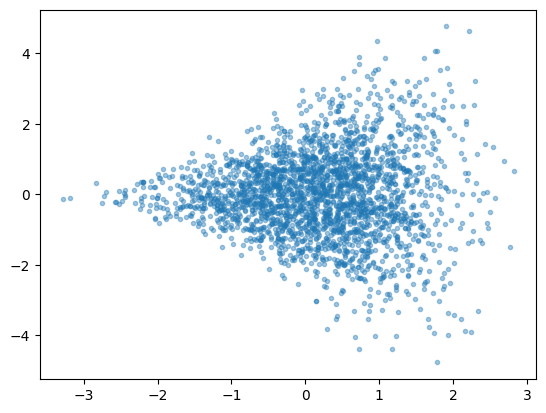

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

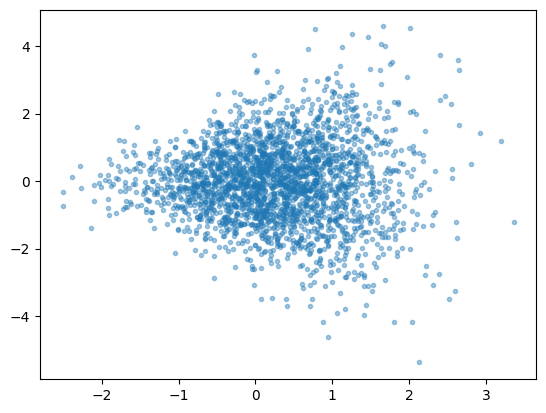

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(0.3355124, dtype=float32)

In [10]:
results_dict["is_eval"]

[0.31130170822143555,
 0.37237548828125,
 0.5079479217529297,
 -0.19354534149169922,
 0.4217557907104492,
 -0.40883541107177734,
 -0.7667903900146484,
 0.35685014724731445,
 0.5120420455932617,
 0.5460119247436523,
 0.41397523880004883,
 0.3598308563232422,
 0.5724530220031738,
 0.5909290313720703,
 0.2540011405944824,
 0.5946469306945801,
 0.22674942016601562,
 0.58233642578125,
 0.5607213973999023,
 0.5245523452758789,
 0.5745015144348145,
 0.36390066146850586,
 -0.4696025848388672,
 0.36411190032958984,
 0.648310661315918,
 0.41677331924438477,
 0.41998291015625,
 0.47897958755493164,
 0.40917491912841797,
 0.5199298858642578]

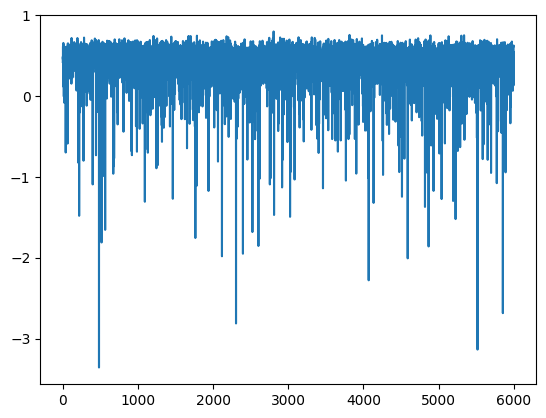

In [11]:
plt.plot(results_dict["is"])

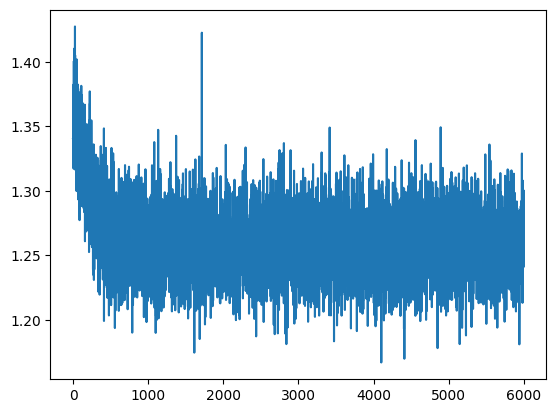

In [12]:
plt.plot(results_dict["elbo"])

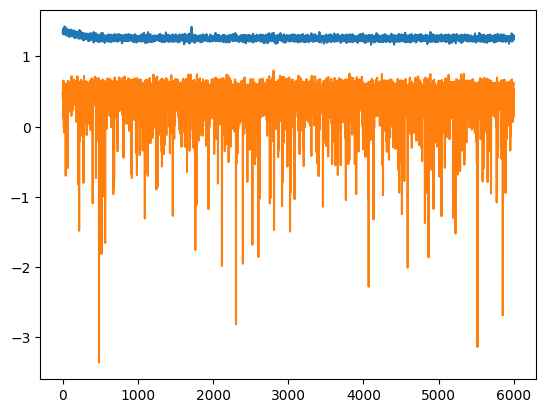

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])